In [4]:
import os, warnings, gc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
companies = ['AFLT', 'GAZP', 'GMKN', 'LKOH', 'NVTK', 'ROSN', 'SBER', 'TCSG', 'VTBR', 'YNDX']

In [17]:
for company in companies:
    df = pd.read_parquet(f'targets/{company}.parquet')
    df['mean_1_min'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    df['mean_5_min'] = (df['mean_1_min'] * df['vol']).rolling(5).sum() / df['vol'].rolling(5).sum()
    df['mean_10_min'] = (df['mean_1_min'] * df['vol']).rolling(10).sum() / df['vol'].rolling(10).sum()
    df['mean_15_min'] = (df['mean_1_min'] * df['vol']).rolling(15).sum() / df['vol'].rolling(15).sum()
    df['mean_30_min'] = (df['mean_1_min'] * df['vol']).rolling(30).sum() / df['vol'].rolling(30).sum()
    df['mean_1_hour'] = (df['mean_1_min'] * df['vol']).rolling(60).sum() / df['vol'].rolling(60).sum()
    df['mean_1_day'] = (df['mean_1_min'] * df['vol']).rolling(60*9).sum() / df['vol'].rolling(60*9).sum()
    df['rate_1_min'] = df['mean_1_min'] / df['mean_1_min'].shift(1) - 1
    df['rate_5_min'] = df['mean_5_min'] / df['mean_5_min'].shift(5) - 1
    df['rate_10_min'] = df['mean_10_min'] / df['mean_10_min'].shift(10) - 1
    df['rate_15_min'] = df['mean_15_min'] / df['mean_15_min'].shift(15) - 1
    df['rate_30_min'] = df['mean_30_min'] / df['mean_30_min'].shift(15) - 1
    df['rate_1_hour'] = df['mean_1_hour'] / df['mean_1_hour'].shift(60) - 1
    df['rate_1_day'] = df['mean_1_day'] / df['mean_1_day'].shift(60*9) - 1
    df.drop(columns=['mean_1_min', 'mean_5_min', 'mean_10_min', 'mean_15_min', 'mean_30_min', 'mean_1_hour', 'mean_1_day'], inplace=True)
    for time, sh in zip(['1_min', '5_min', '10_min', '15_min', '30_min', '1_hour', '1_day'],
                   [1, 5, 10, 15, 30, 60, 60*9]):
        for i in range(10):
            df[f'{time}_lag_{i}'] = df[f'rate_{time}'].shift(i * sh)
            
    df.to_parquet(f'targets/{company}.parquet')

In [20]:
first_dates = pd.DataFrame(index=companies)
first_dates['date'] = 0

for company in companies:
    df = pd.read_parquet(f'targets/{company}.parquet')
    df.dropna(inplace=True)
    df.reset_index(inplace=True, drop=True)
    first_dates.loc[company, 'date'] = df['date'][0]

In [4]:
data = pd.read_parquet('C:/Users/ап/Рабочий стол/Нейросети для исследований научка/data.parquet')

In [7]:
data = data.iloc[:,:15].copy()

In [14]:
data.sort_values('date', inplace=True, ignore_index=True)
data_with_lags = pd.DataFrame()
for company in companies:
    print(f'{company}')
    targets = pd.read_parquet(f'D:/Жора/Data/targets/{company}.parquet')
    targets['date'] = targets['date'].astype('datetime64[ns]')
    df = data[data[company] == True].copy()
    df['date'] += pd.Timedelta(1, 'sec')
    merged = pd.merge_asof(df, targets, on='date', direction='backward')
    merged['date'] -= pd.Timedelta(1, 'sec')
    merged['company'] = company
    data_with_lags = pd.concat([data_with_lags, merged])
data_with_lags.drop_duplicates(inplace=True)
data_with_lags.reset_index(drop=True, inplace=True)

AFLT
GAZP
GMKN
LKOH
NVTK
ROSN
SBER
TCSG
VTBR
YNDX


In [16]:
data_with_lags.to_parquet('data.parquet')

In [17]:
data = pd.read_parquet('data.parquet')

In [18]:
def mapper(x):
    if x == 2:
        return 2
    if x == -2:
        return 0
    if x == 0:
        return 1

In [37]:
data_with_targets = pd.DataFrame()
data = pd.read_parquet('data.parquet')
data.sort_values('date', inplace=True, ignore_index=True)

# data.drop_duplicates(['message_lemm'], inplace=True)
times = ['5_min', '10_min', '15_min', '30_min', '1_hour', '1_day']
for company in companies:
    print(f'{company}')
    df = pd.read_parquet(f'D:/Жора/Data/targets/{company}.parquet')
    df['date'] = df['date'].astype('datetime64[ns]')
    for time, sh in zip(times, [5, 10, 15, 30, 60, 60*9]):
        df[f'{time}_2_cls'] = df[f'{time}_lag_0'] < df[f'rate_{time}'].shift(-sh)
        cols_for_std = [f'{time}_lag_{i}' for i in range(10)]
        if time != '1_min':
            means = df[cols_for_std].mean(axis=1)
            stds = df[cols_for_std].std(axis=1)
            neg_type = (df[f'{time}_lag_0'] > means - 1 * stds).astype(int)
            pos_type = (df[f'{time}_lag_0'] > means + 1 * stds).astype(int)
            df[f'{time}_3_cls'] = neg_type + pos_type
    
    cols_cls = [f'{time}_2_cls' for time in times] + [f'{time}_3_cls' for time in times]
    df = df[['date', *cols_cls]].copy()
    data_slice = data[data['company'] == company].copy()
    data_slice['date'] += pd.Timedelta(1, 'sec')
    merged = pd.merge_asof(data_slice, df, on='date', direction='backward')
    merged['date'] -= pd.Timedelta(1, 'sec')
    data_with_targets = pd.concat([data_with_targets, merged])
    
data_with_targets.drop_duplicates(inplace=True, ignore_index=True)

AFLT
GAZP
GMKN
LKOH
NVTK
ROSN
SBER
TCSG
VTBR
YNDX


In [63]:
data_with_targets.dropna(inplace=True, ignore_index=True)
data_with_targets.to_parquet('data.parquet')

(array([1136.,    0.,    0.,    0.,    0., 4421.,    0.,    0.,    0.,
        1447.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

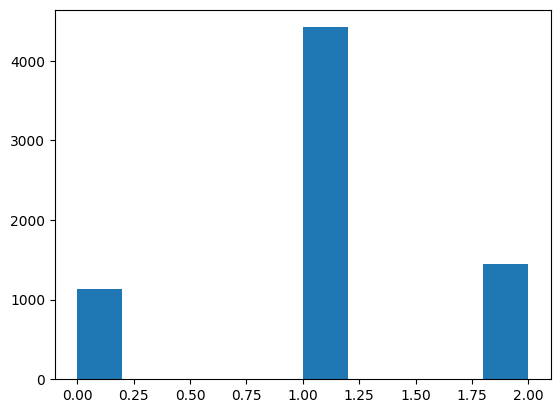

In [62]:
plt.hist(data_with_targets[data_with_targets['company'] == 'LKOH']['10_min_3_cls'])

In [53]:
gazoil_comps = ['GAZP', 'ROSN', 'LKOH', 'NVTK']
finance_comps = ['SBER', 'VTBR', 'TCSG']
df = pd.read_parquet('data.parquet')

In [54]:
df_gasoil = df[df['company'].isin(gazoil_comps)]
df_gasoil = df_gasoil[['date', 'message_lemm', 'message_raw', 'company']].copy()
df_gasoil['index_for_bert'] = df_gasoil.index
df_gasoil.sort_values('date', ignore_index=True, inplace=True)

In [55]:
df_gasoil['date'] += pd.Timedelta(1, 'sec')
for company in gazoil_comps:
    print(f'{company}')
    targets = pd.read_parquet(f'D:/Жора/Data/targets/{company}.parquet')
    lag_cols_old = [col for col in targets.columns if ('lag' in col) and ('1_min' not in col)]
    lag_cols_new = [f'{company}_{col}' for col in lag_cols_old]
    targets.rename(columns={i:j for i, j in zip(lag_cols_old, lag_cols_new)}, inplace=True)
    targets['date'] = targets['date'].astype('datetime64[ns]')
  
    df_gasoil = pd.merge_asof(df_gasoil, targets[['date', *lag_cols_new]], on='date', direction='backward')

df_gasoil['date'] -= pd.Timedelta(1, 'sec')

GAZP
ROSN
LKOH
NVTK


In [56]:
df_gasoil.to_parquet('data_gazoil.parquet')

In [69]:
df_finance = df[df['company'].isin(finance_comps)]
df_finance = df_finance[['date', 'message_lemm', 'message_raw', 'company']].copy()
df_finance['index_for_bert'] = df_finance.index
df_finance.sort_values('date', ignore_index=True, inplace=True)

In [76]:
first_date = pd.read_csv('D:/Жора/Data/first_dates.csv', index_col=0).loc['TCSG', 'date']
df_finance = df_finance[df_finance['date'] >= first_date].copy().reset_index(drop=True)

In [78]:
df_finance['date'] += pd.Timedelta(1, 'sec')
for company in finance_comps:
    print(f'{company}')
    targets = pd.read_parquet(f'D:/Жора/Data/targets/{company}.parquet')
    lag_cols_old = [col for col in targets.columns if ('lag' in col) and ('1_min' not in col)]
    lag_cols_new = [f'{company}_{col}' for col in lag_cols_old]
    targets.rename(columns={i:j for i, j in zip(lag_cols_old, lag_cols_new)}, inplace=True)
    targets['date'] = targets['date'].astype('datetime64[ns]')
  
    df_finance = pd.merge_asof(df_finance, targets[['date', *lag_cols_new]], on='date', direction='backward')

df_finance['date'] -= pd.Timedelta(1, 'sec')

SBER
VTBR
TCSG


In [79]:
df_finance.to_parquet('data_finance.parquet')

In [80]:
data_with_targets = pd.DataFrame()
data = pd.read_parquet('data.parquet')
data.sort_values('date', inplace=True, ignore_index=True)

# data.drop_duplicates(['message_lemm'], inplace=True)
times = ['5_min', '10_min', '15_min', '30_min', '1_hour', '1_day']
for company in gazoil_comps:
    print(f'{company}')
    df = pd.read_parquet(f'D:/Жора/Data/targets/{company}.parquet')
    df['date'] = df['date'].astype('datetime64[ns]')
    for time, sh in zip(times, [5, 10, 15, 30, 60, 60*9]):
        df[f'{company}_{time}_2_cls'] = df[f'{time}_lag_0'] < df[f'rate_{time}'].shift(-sh)
        cols_for_std = [f'{time}_lag_{i}' for i in range(10)]

        means = df[cols_for_std].mean(axis=1)
        stds = df[cols_for_std].std(axis=1)
        neg_type = (df[f'{time}_lag_0'] > means - 1 * stds).astype(int)
        pos_type = (df[f'{time}_lag_0'] > means + 1 * stds).astype(int)
        df[f'{company}_{time}_3_cls'] = neg_type + pos_type
    
    cols_cls = [f'{company}_{time}_2_cls' for time in times] + [f'{company}_{time}_3_cls' for time in times]
    df = df[['date', *cols_cls]].copy()
    
    df_gasoil['date'] += pd.Timedelta(1, 'sec')
    df_gasoil = pd.merge_asof(df_gasoil, df, on='date', direction='backward')
    df_gasoil['date'] -= pd.Timedelta(1, 'sec')

GAZP
ROSN
LKOH
NVTK


In [84]:
data_with_targets = pd.DataFrame()
data = pd.read_parquet('data.parquet')
data.sort_values('date', inplace=True, ignore_index=True)

# data.drop_duplicates(['message_lemm'], inplace=True)
times = ['5_min', '10_min', '15_min', '30_min', '1_hour', '1_day']
for company in finance_comps:
    print(f'{company}')
    df = pd.read_parquet(f'D:/Жора/Data/targets/{company}.parquet')
    df['date'] = df['date'].astype('datetime64[ns]')
    for time, sh in zip(times, [5, 10, 15, 30, 60, 60*9]):
        df[f'{company}_{time}_2_cls'] = df[f'{time}_lag_0'] < df[f'rate_{time}'].shift(-sh)
        cols_for_std = [f'{time}_lag_{i}' for i in range(10)]

        means = df[cols_for_std].mean(axis=1)
        stds = df[cols_for_std].std(axis=1)
        neg_type = (df[f'{time}_lag_0'] > means - 1 * stds).astype(int)
        pos_type = (df[f'{time}_lag_0'] > means + 1 * stds).astype(int)
        df[f'{company}_{time}_3_cls'] = neg_type + pos_type
    
    cols_cls = [f'{company}_{time}_2_cls' for time in times] + [f'{company}_{time}_3_cls' for time in times]
    df = df[['date', *cols_cls]].copy()
    
    df_finance['date'] += pd.Timedelta(1, 'sec')
    df_finance = pd.merge_asof(df_finance, df, on='date', direction='backward')
    df_finance['date'] -= pd.Timedelta(1, 'sec')

SBER
VTBR
TCSG


In [83]:
df_gasoil.to_parquet('data_gazoil.parquet')

In [85]:
df_finance.to_parquet('data_finance.parquet')